In [1]:
%autosave 60

Autosaving every 60 seconds


### Импорт библиотек

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

from phik import resources
from phik.report import plot_correlation_matrix

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

import optuna
import shap

from IPython.display import display, Image

In [3]:
plt.style.use('cyberpunk')

# ML 1
---

## Intro

Ник на Kaggle: **KsyLight** <br>
Итоговая позиция: **18**

### Скрины

**Позиция в контесте**

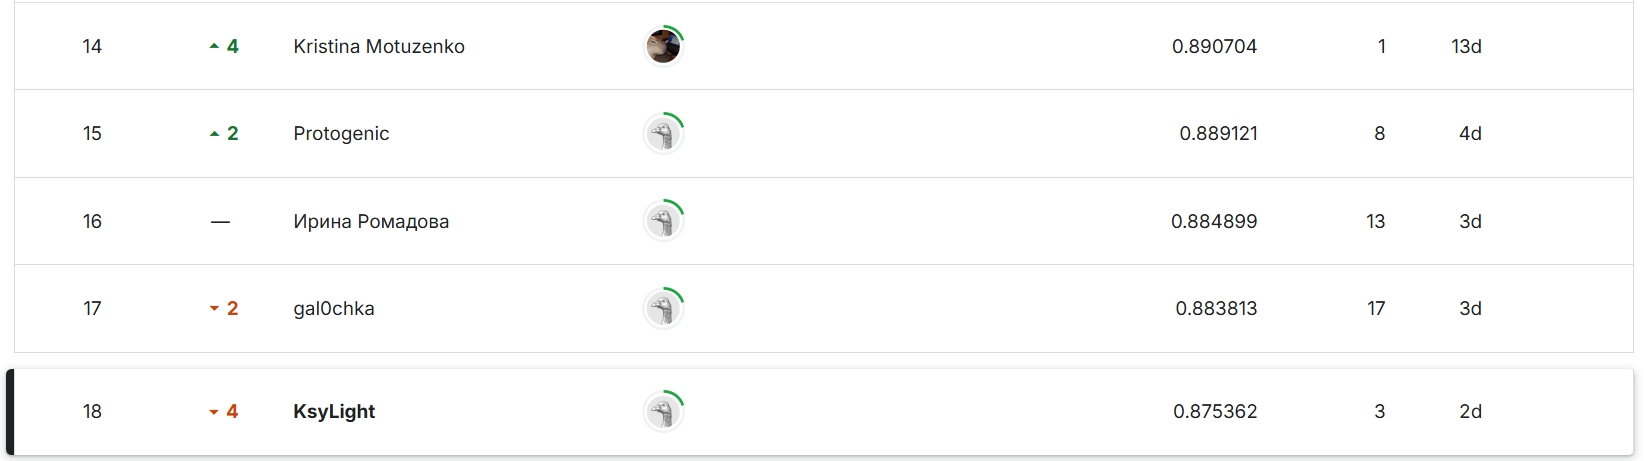

In [40]:
display(Image(filename="photo1.jpeg"))

**Список всех сабмитов**

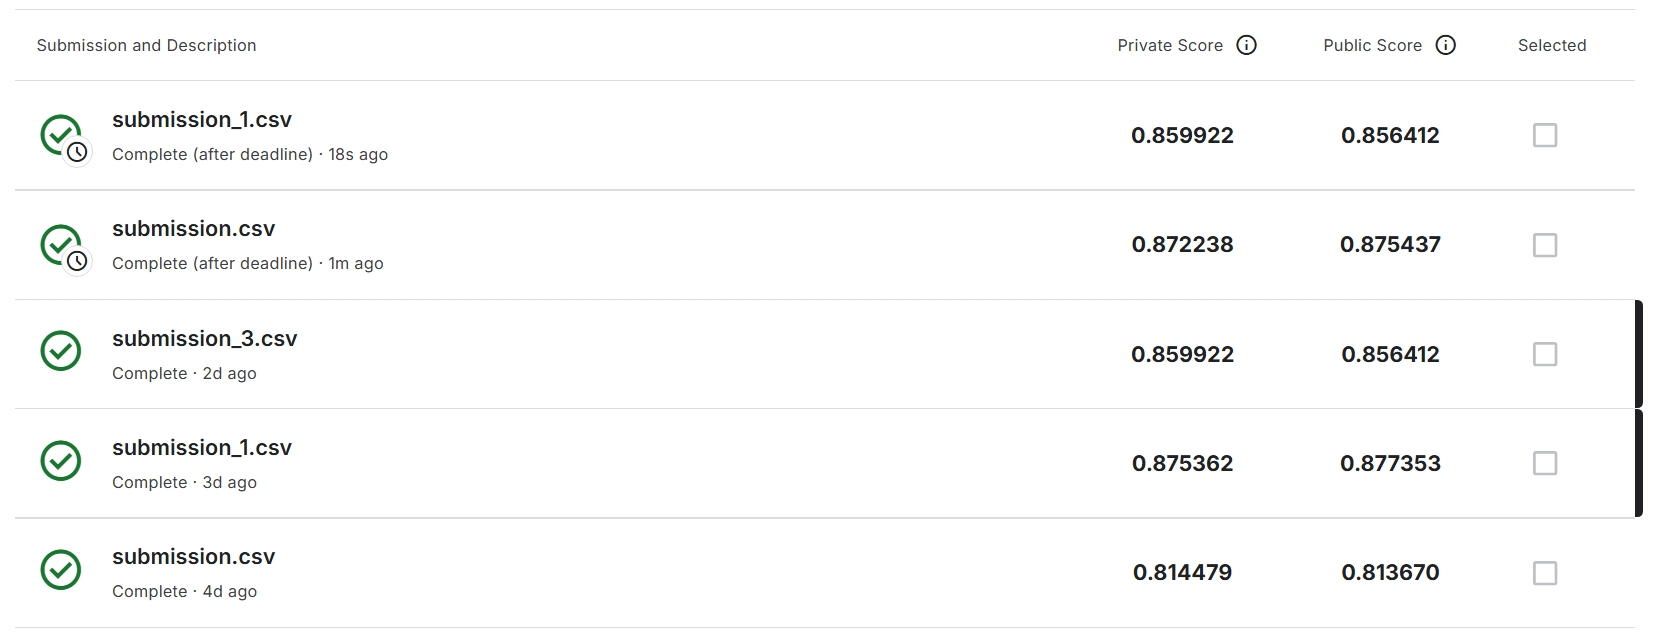

In [41]:
display(Image(filename="photo2.jpeg"))

Цель проекта заключалась в построении модели бинарной классификации, способной с высокой точностью предсказывать, является ли транзакция мошеннической, на основе признаков.

1. **Предобработка данных**:
   - Из временного признака `transaction_time` выделены `hour`, `dayofweek`, `month`, `is_weekend`.
   - Признак `amount` был логарифмирован с помощью `np.log1p` для устранения сдвига и уменьшения влияния выбросов.
   - Категориальные признаки были закодированы встроенными средствами `CatBoost`, не требуя явного One-Hot Encoding.
   - Пропущенных значений не было, а выбросы я решил не трогать.
   - Проведён анализ дисбаланса классов, внесены корректировки.
<br>
<br>
2. **Выбор алгоритма**:
   - Выбран `CatBoostClassifier`, так как он хорошо работает с табличными данными, автоматически обрабатывает категориальные признаки, устойчив к пропускам и не требует дополнительного кодирования.
   - В процессе обучения использовалась функция потерь **logloss**, стандартная для задач бинарной классификации, позволяющая оптимизировать вероятностные предсказания.
<br>
<br>
3. **Особенности обучения**:
   - Для оптимизации гиперпараметров использовалась Optuna.
   - Для компенсации дисбаланса использован параметр `class_weights`.
   - Для интерпретации признаков применён анализ SHAP (графики важности и влияния признаков).
<br>
<br>
4. **Валидация и метрика**:
   - Данные разделены на обучающую и валидационную выборки с помощью `train_test_split` (c `random_state=42`).
   - Основной метрикой выбрана **F1-score**, так как она сбалансированно учитывает точность и полноту — это критически важно для задач, связанных с выявлением мошенничества.

### Загрузка датасетов

In [4]:
df_2 = pd.read_csv('test.csv')
df_1 = pd.read_csv('train.csv')
sample_submition = pd.read_csv('sample_submition.csv')

## EDA-анализ

### Общая информация

In [5]:
display(sample_submition.sample(5))

,index,prediction
68037,68037,0
121898,121898,0
259464,259464,0
59790,59790,0
168127,168127,0


In [6]:
datasets = [df_1, df_2]

In [7]:
for dataset in datasets:
    display(dataset.head(3))

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0
2,2019-09-23 15:02,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.8788,-82.1880,1831,Barrister's clerk,40.010874,-81.841249,0


,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon
0,2019-09-14 02:46,"fraud_Stokes, Christiansen and Sipes",grocery_net,25.79,Michael,Rodriguez,M,172 Paula Inlet Apt. 650,Cross Plains,TX,76443,32.1482,-99.1872,1897,Chief Operating Officer,31.772057,-99.103183
1,2019-07-25 20:30,fraud_Thompson-Gleason,health_fitness,87.80,Curtis,Young,M,4319 Watson Shoals Suite 658,Falconer,NY,14733,42.1239,-79.1895,3833,Metallurgist,42.635312,-78.334559
2,2020-01-05 17:27,fraud_Friesen Inc,shopping_pos,10.98,Brandy,Quinn,F,9734 Beard Fields Suite 885,Altair,TX,77412,29.6047,-96.5249,106,"Editor, film/video",29.363782,-95.624994


In [8]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

### Пропуски и дубликаты

In [9]:
for dataset in datasets:
    print("Количество пропусков в абсолютных и относительных значениях:")
    display(pd.DataFrame({
    'Total NaN': dataset.isna().sum(),
    'Percentage NaN': dataset.isna().mean() * 100
    }).style.background_gradient('coolwarm').format({'Percentage NaN': '{:.2f}%'}))

Количество пропусков в абсолютных и относительных значениях:


,Total NaN,Percentage NaN
transaction_time,0,0.00%
merch,0,0.00%
cat_id,0,0.00%
amount,0,0.00%
name_1,0,0.00%
name_2,0,0.00%
gender,0,0.00%
street,0,0.00%
one_city,0,0.00%
us_state,0,0.00%


Количество пропусков в абсолютных и относительных значениях:


,Total NaN,Percentage NaN
transaction_time,0,0.00%
merch,0,0.00%
cat_id,0,0.00%
amount,0,0.00%
name_1,0,0.00%
name_2,0,0.00%
gender,0,0.00%
street,0,0.00%
one_city,0,0.00%
us_state,0,0.00%


In [10]:
df_1.duplicated().sum()

0

### Распределение классов

In [11]:
display(df_1['target'].value_counts(normalize=True))  # Относительные частоты
display(df_1['target'].value_counts()) 

target
0    0.994273
1    0.005727
Name: proportion, dtype: float64

target
0    781927
1      4504
Name: count, dtype: int64

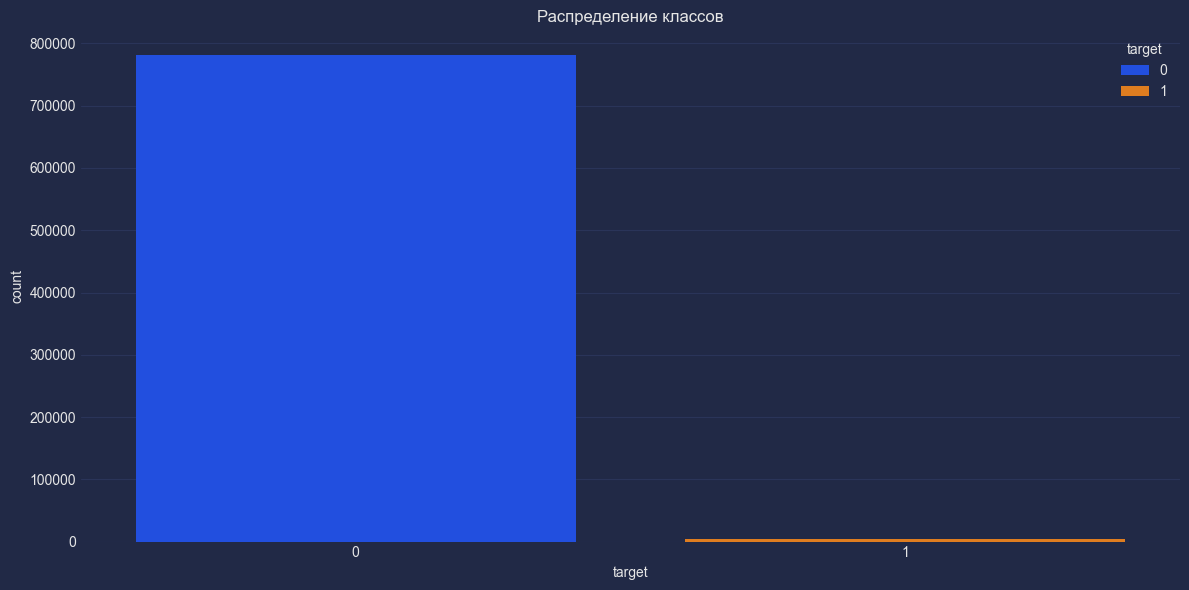

In [12]:
plt.figure(figsize=(12,6))

sns.countplot(x=df_1['target'], hue=df_1['target'], palette='bright')
plt.title("Распределение классов")

plt.tight_layout()
plt.show()

### Распределения численных признаков

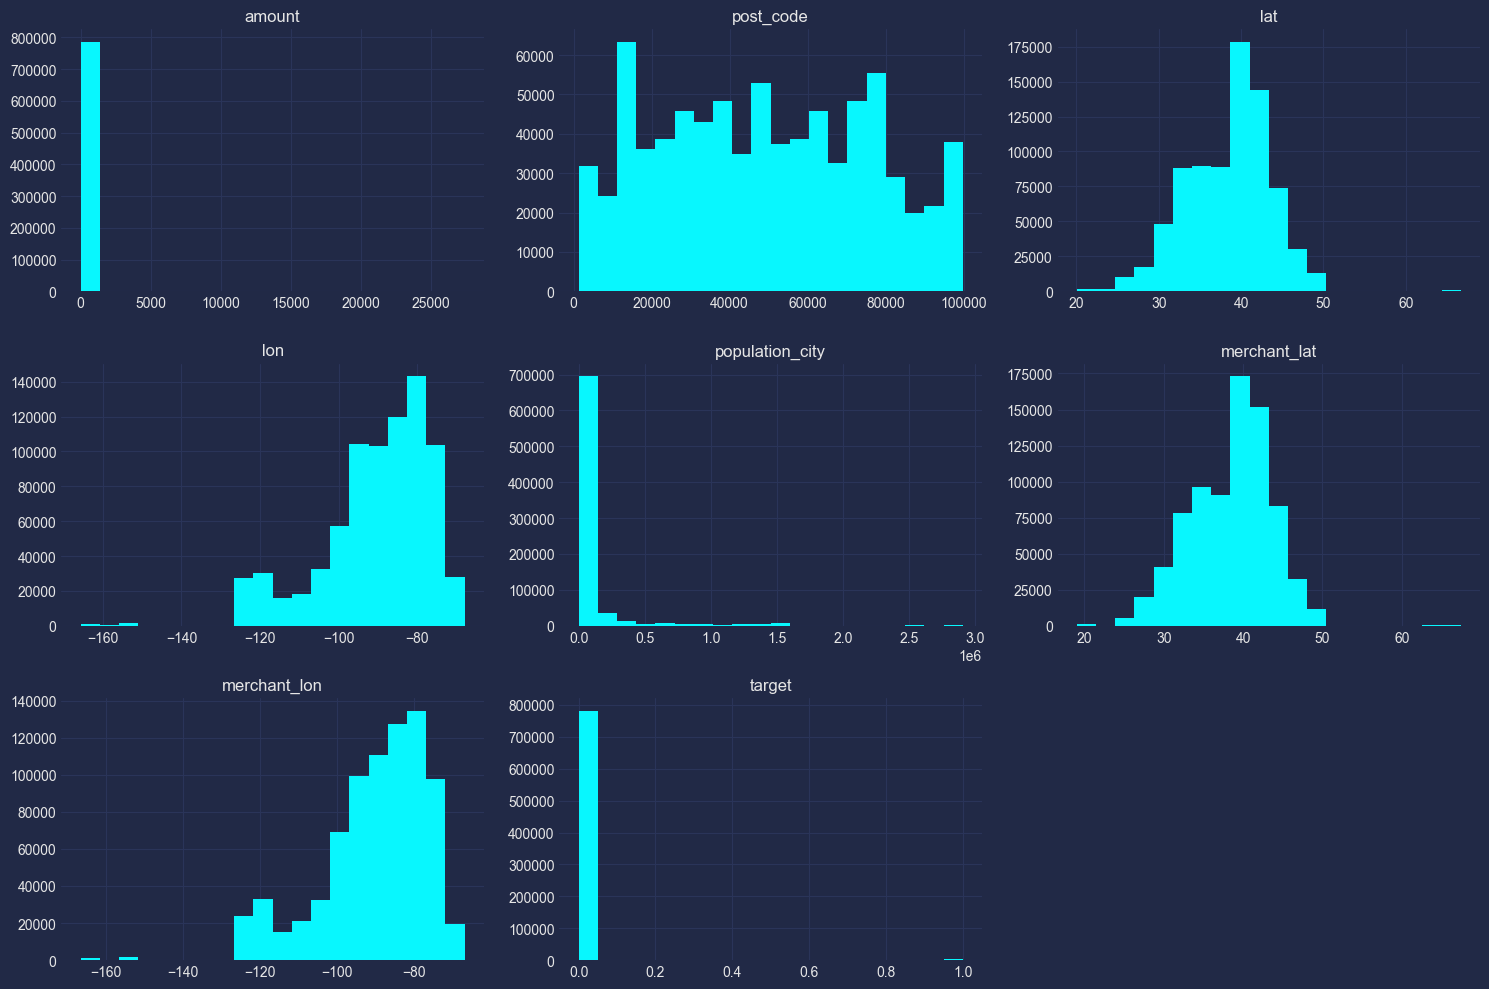

In [13]:
num_cols = df_1.select_dtypes(include=['int64', 'float64']).columns
df_1[num_cols].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

### Количество уникальных значений по категориальным столбцам

In [14]:
df_1['transaction_time'] = pd.to_datetime(df_1['transaction_time'])
categorical_cols = df_1.select_dtypes(include='object').columns.tolist()

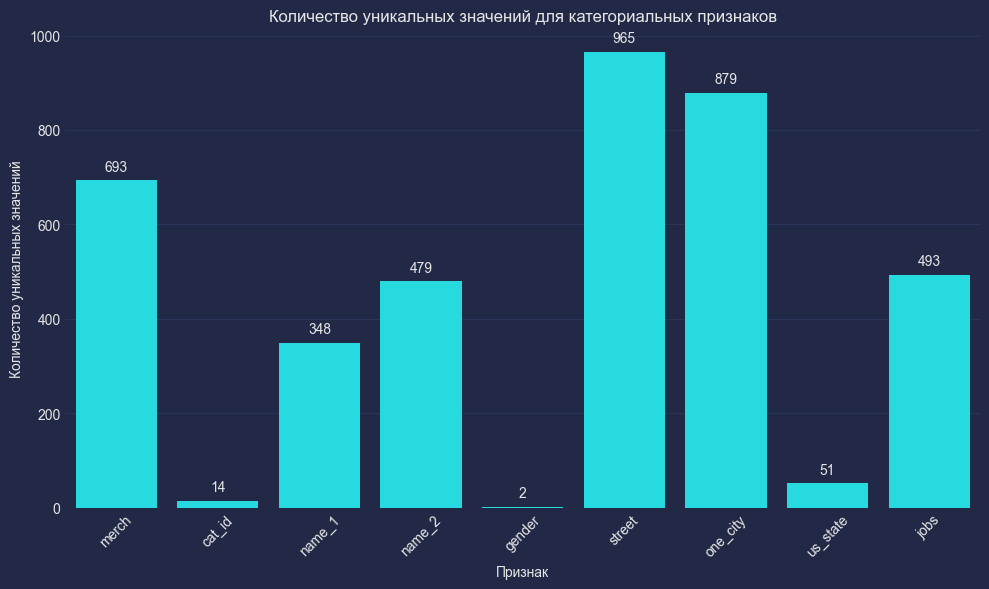

In [15]:
# Для каждого категориального признака считаем количество уникальных значений
cardinality = pd.DataFrame({
    'feature': categorical_cols,
    'nunique': [df_1[col].nunique() for col in categorical_cols]
})

# Визуализируем с помощью bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='feature', y='nunique', data=cardinality)

# Добавляем подписи с количеством уникальных значений над каждым столбцом
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)
plt.title("Количество уникальных значений для категориальных признаков")
plt.xlabel("Признак")
plt.ylabel("Количество уникальных значений")
plt.tight_layout()
plt.show()

In [16]:
threshold = 100

high_cardinality_cols = []
for col in categorical_cols:
    num_unique = df_1[col].nunique()
    if num_unique > threshold:
        high_cardinality_cols.append(col)
        print(f"Признак '{col}' имеет {num_unique} уникальных значений (высокая кардинальность).")

Признак 'merch' имеет 693 уникальных значений (высокая кардинальность).
Признак 'name_1' имеет 348 уникальных значений (высокая кардинальность).
Признак 'name_2' имеет 479 уникальных значений (высокая кардинальность).
Признак 'street' имеет 965 уникальных значений (высокая кардинальность).
Признак 'one_city' имеет 879 уникальных значений (высокая кардинальность).
Признак 'jobs' имеет 493 уникальных значений (высокая кардинальность).


In [17]:
high_cardinality_cols

['merch', 'name_1', 'name_2', 'street', 'one_city', 'jobs']

### Корреляция

C:\Users\MSI\env_py_3_12\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable transaction_time is large: 419851. Are you sure this is not an interval variable? Analysis for pairs of variables including transaction_time can be slow.
  warnings.warn(


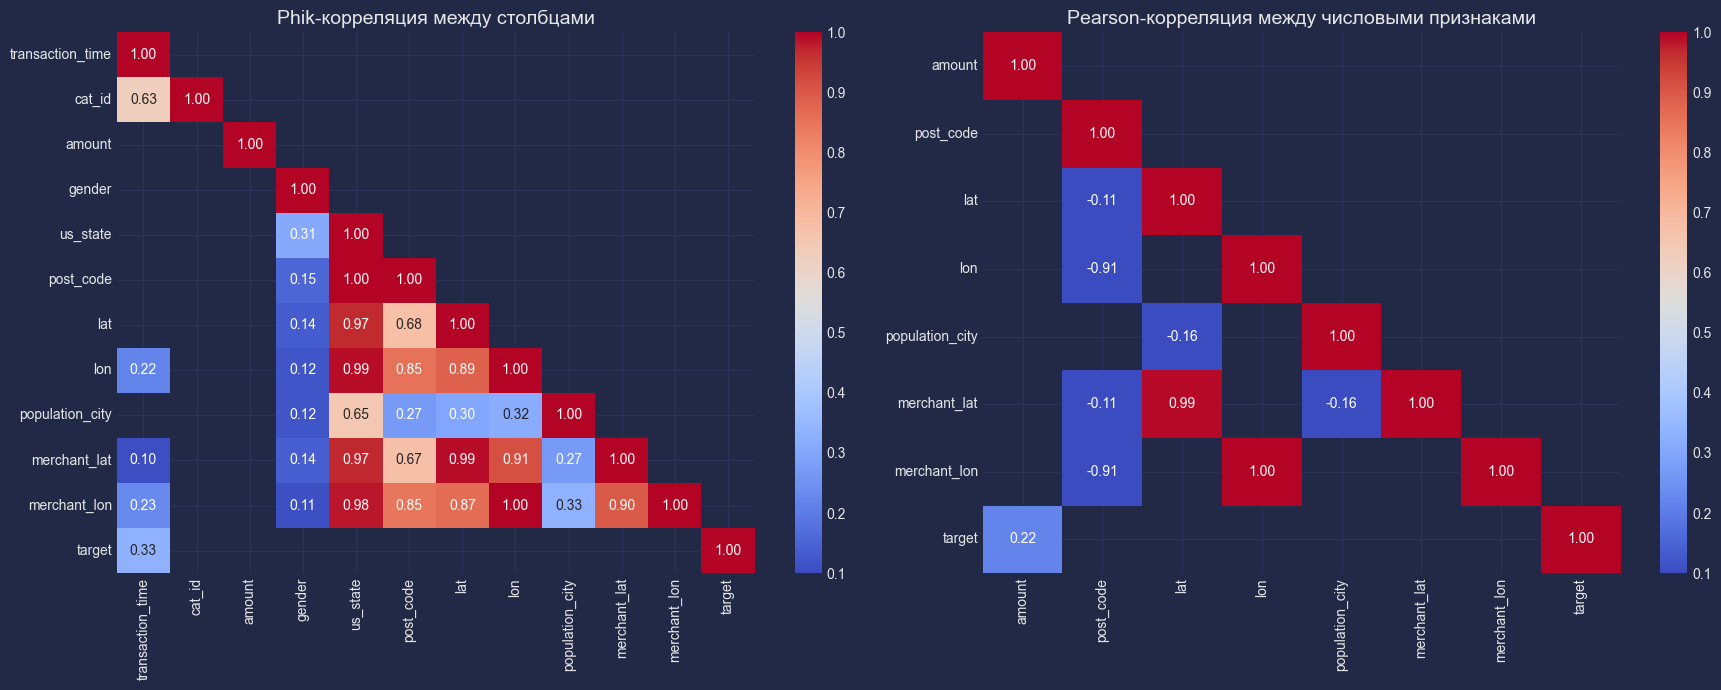

In [44]:
# Указываем интервальные (числовые) признаки
interval_cols = ['amount', 'post_code', 'lat', 'lon', 'population_city', 'merchant_lat', 'merchant_lon', 'target']

# Исключаем признаки с очень большим числом уникальных значений (если нужно)
df_phik = df_1.drop(columns=high_cardinality_cols, errors='ignore')

# PHIK корреляция
phik_corr = df_phik.phik_matrix(interval_cols=interval_cols)

# Маска и фильтрация слабых значений
mask_phik = np.triu(np.ones_like(phik_corr, dtype=bool), k=1)
phik_corr_filtered = phik_corr.copy()
phik_corr_filtered[phik_corr_filtered < 0.1] = np.nan

# Pearson корреляция для числовых признаков
num_cols = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df_1[num_cols].corr(method='pearson')

mask_pearson = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_filtered = corr.copy()
corr_filtered[corr_filtered.abs() < 0.1] = np.nan

# Построение двух тепловых карт рядом
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Левая — Phik
sns.heatmap(phik_corr_filtered, mask=mask_phik, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1, ax=axes[0])
axes[0].set_title("Phik-корреляция между столбцами", fontsize=14)

# Правая — Pearson
sns.heatmap(corr_filtered, mask=mask_pearson, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1, ax=axes[1])
axes[1].set_title("Pearson-корреляция между числовыми признаками", fontsize=14)

plt.tight_layout()
plt.show()

## Подготовка данных

In [18]:
train = df_1.copy()
test = df_2.copy()

In [19]:
def preprocess(df):
    df = df.copy()

    df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')

    df['hour'] = df['transaction_time'].dt.hour
    df['dayofweek'] = df['transaction_time'].dt.dayofweek
    df['month'] = df['transaction_time'].dt.month
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    df.drop(columns=['transaction_time'], inplace=True, errors='ignore')

    if 'amount' in df.columns:
        df['amount_log'] = np.log1p(df['amount'])

    return df

In [20]:
train = preprocess(train)
test = preprocess(test)

In [21]:
# Определяем целевую переменную и признаки
y = train['target']
X = train.drop('target', axis=1)

# Определяем список категориальных признаков
cat_features = ['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs']

In [22]:
# Разбиваем данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Создаем объекты Pool для CatBoost, передавая список категориальных признаков
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

## Обучение модели на `train.csv` с использованием Logloss как функции потерь

### Аналог лучшей модели по скору с небольшой погрешностью

In [23]:
def objective_logloss(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 750),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'class_weights': [1, trial.suggest_float('class_weight_pos', 5, 15)],
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'random_seed': 42,
        'verbose': 0
    }
    
    # Создаём модель с текущими гиперпараметрами
    model = CatBoostClassifier(**params)
    
    # Обучаем модель
    model.fit(
        train_pool, 
        eval_set=valid_pool,
        early_stopping_rounds=30,
        verbose=False  # чтобы не засорять вывод
    )
    
    # Предсказываем и считаем F1 на валидации
    preds = model.predict(data=X_valid)
    score = f1_score(y_valid, preds)
    
    return score

# Создаём исследование Optuna и запускаем оптимизацию
study_logloss = optuna.create_study(direction='maximize')
study_logloss.optimize(objective_logloss, n_trials=30) 

# Выводим лучшие найденные параметры и лучший F1
print("Logloss: лучшие параметры:", study_logloss.best_trial.params)
print("Logloss: лучший F1:", study_logloss.best_trial.value)

[I 2025-03-29 22:20:23,583] A new study created in memory with name: no-name-f6e37b59-c6c6-4b2e-9224-be33c08057c9
[I 2025-03-29 22:27:09,357] Trial 0 finished with value: 0.7703851925962981 and parameters: {'iterations': 604, 'learning_rate': 0.010641273524531114, 'depth': 9, 'l2_leaf_reg': 0.0020881425193461267, 'class_weight_pos': 14.04580513427645}. Best is trial 0 with value: 0.7703851925962981.
[I 2025-03-29 22:30:04,179] Trial 1 finished with value: 0.7090558766859345 and parameters: {'iterations': 356, 'learning_rate': 0.018981464026368588, 'depth': 4, 'l2_leaf_reg': 8.592859127493725, 'class_weight_pos': 11.283372073167016}. Best is trial 0 with value: 0.7703851925962981.
[I 2025-03-29 22:32:21,090] Trial 2 finished with value: 0.680184331797235 and parameters: {'iterations': 484, 'learning_rate': 0.020457296815694304, 'depth': 4, 'l2_leaf_reg': 0.12316381304851871, 'class_weight_pos': 14.572850580668897}. Best is trial 0 with value: 0.7703851925962981.
[I 2025-03-29 22:43:47,7

Logloss: лучшие параметры: {'iterations': 393, 'learning_rate': 0.09371918237383885, 'depth': 7, 'l2_leaf_reg': 1.2280534351971226, 'class_weight_pos': 6.883940459326707}
Logloss: лучший F1: 0.8810182623132263


In [24]:
study_logloss.best_trial.params

{'iterations': 393,
 'learning_rate': 0.09371918237383885,
 'depth': 7,
 'l2_leaf_reg': 1.2280534351971226,
 'class_weight_pos': 6.883940459326707}

In [25]:
best_params_logloss = study_logloss.best_trial.params.copy()

best_params_logloss['class_weights'] = [1, best_params_logloss.pop('class_weight_pos')]

# Добавляем остальные фиксированные параметры
best_params_logloss['loss_function'] = 'Logloss'
best_params_logloss['eval_metric'] = 'F1'
best_params_logloss['use_best_model'] = True

# Создаем и обучаем финальную модель
model_logloss = CatBoostClassifier(**best_params_logloss)
model_logloss.fit(
    train_pool,
    eval_set=valid_pool,
    early_stopping_rounds=30,
    verbose=50
)

# Проверяем итоговый F1
y_pred_logloss = model_logloss.predict(X_valid)
score_logloss = f1_score(y_valid, y_pred_logloss)
print("Итоговый F1 для Logloss:", score_logloss)

0:	learn: 0.7630335	test: 0.7471309	best: 0.7471309 (0)	total: 1.13s	remaining: 7m 22s
50:	learn: 0.8996827	test: 0.8904060	best: 0.8904060 (50)	total: 57.4s	remaining: 6m 24s
100:	learn: 0.9188864	test: 0.9065041	best: 0.9073045 (93)	total: 1m 54s	remaining: 5m 32s
150:	learn: 0.9335704	test: 0.9143360	best: 0.9150507 (137)	total: 2m 50s	remaining: 4m 34s
200:	learn: 0.9427872	test: 0.9214512	best: 0.9214512 (198)	total: 3m 50s	remaining: 3m 39s
250:	learn: 0.9497018	test: 0.9230171	best: 0.9235682 (245)	total: 4m 46s	remaining: 2m 41s
300:	learn: 0.9568870	test: 0.9280371	best: 0.9280371 (300)	total: 5m 43s	remaining: 1m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9285044217
bestIteration = 303

Shrink model to first 304 iterations.
Итоговый F1 для Logloss: 0.8724685276409414


## Формирование `submission_№.csv` на основе `train.csv`

In [26]:
# Если в обучении использовался столбец 'jobs' как категориальный, добавьте его в список, если он присутствует
cat_features = ['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs']

test_ids = pd.Series(test.index, name='id')

# Подготовка данных для CatBoost
test_pool = Pool(data=test, cat_features=cat_features)

predictions = model_logloss.predict(test_pool)

# Формирование submission файла согласно sample_submission.csv
submission = pd.DataFrame({
    'index': test_ids,
    'prediction': predictions
})

# Сохранение файла
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


## Обучения на гиперпараметрах, на которых была обучена засабмиченная модель

Это гиперпараметры для второй лучшей модели - вероятно, я забыл сохранить оптимальные, но модель перед этой выбивает почти такой же результат, как и моя лучшая - тут сугубо вопрос гиперпараметров, ибо остальное все сделано так же. Подтверждение скора в скринах

In [29]:
model_logloss_1 = CatBoostClassifier(
    iterations=432,
    learning_rate=0.08898404862169879,
    depth=7,
    l2_leaf_reg=2.1571559164979157,
    class_weights=[1, 5.677531099882749],
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=0
)

model_logloss_1.fit(
    train_pool,
    eval_set=valid_pool,
    early_stopping_rounds=30,
    verbose=50
)

# Проверяем итоговый F1
y_pred_logloss = model_logloss_1.predict(X_valid)
score_logloss = f1_score(y_valid, y_pred_logloss)
print("Итоговый F1 для Logloss:", score_logloss)

0:	learn: 0.7801930	test: 0.7685477	best: 0.7685477 (0)	total: 1.01s	remaining: 7m 17s
50:	learn: 0.8971100	test: 0.8874003	best: 0.8874003 (50)	total: 1m 1s	remaining: 7m 41s
100:	learn: 0.9139047	test: 0.9022816	best: 0.9022816 (100)	total: 2m 2s	remaining: 6m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9040530332
bestIteration = 111

Shrink model to first 112 iterations.
Итоговый F1 для Logloss: 0.8477777777777777


In [37]:
# Если в обучении использовался столбец 'jobs' как категориальный, добавьте его в список, если он присутствует
cat_features = ['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs']

predictions_1 = model_logloss_1.predict(test_pool)

# Формирование submission файла согласно sample_submission.csv
submission_1 = pd.DataFrame({
    'index': test_ids,
    'prediction': predictions_1
})

# Сохранение файла
submission_1.to_csv("submission_1.csv", index=False)
print("Submission file saved as submission_1.csv")

Submission file saved as submission_1.csv


## Что пробовали

- Были протестированы базовые модели (`LogisticRegression`, `RandomForestClassifier`, `LightGBM`);
- Изучались различные комбинации признаков и способы их агрегации;
- Пробовались методы уменьшения размерности и отбора признаков;
- CatBoost показал наилучшее соотношение качества, скорости и интерпретируемости.

## Что пошло не так

- Отсутствие кросс-валидации может привести к переобучению на валидационную выборку;
- Некоторые категориальные признаки, такие как `terminal_id`, имеют большое количество уникальных значений — они могли вносить шум;
- При другом `random_state` модель могла бы давать иные результаты, что говорит о нестабильности.

## Анализ с помощью Shap

В целом, я сделал этот анализ еще перед финальной моделью, но в итоге и не применил, хотя было би полезно поработать с признаками ещё.

### Модель, приближенная к лучшей попытке

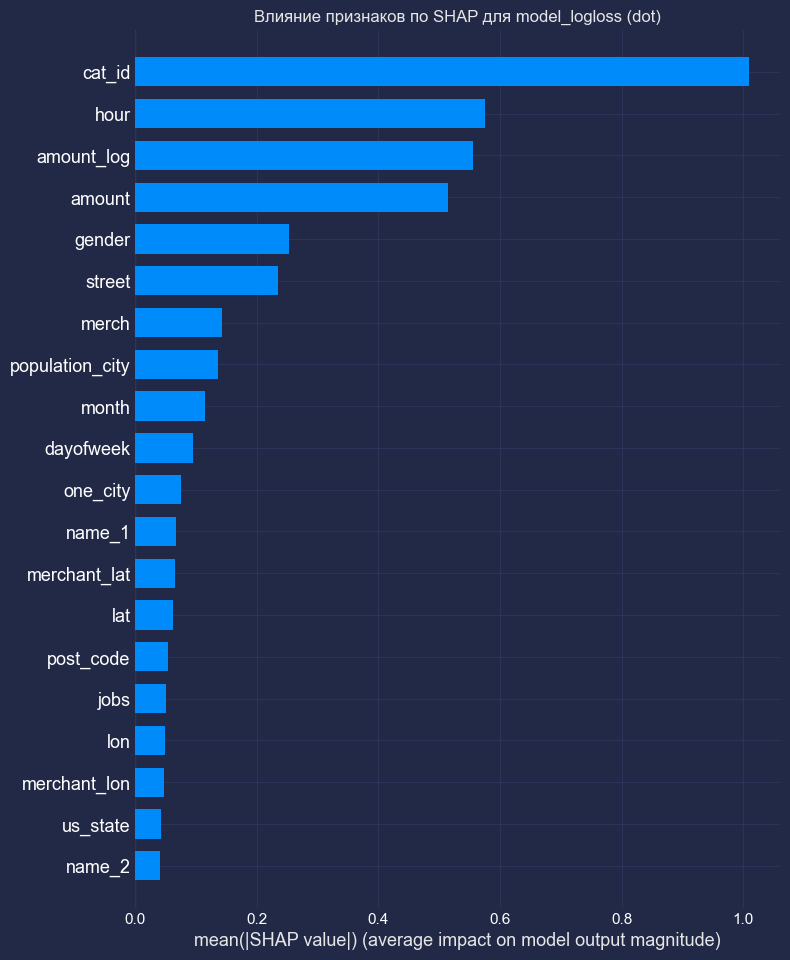

In [32]:
feature_names = X_valid.columns

# Получаем SHAP-значения. Для бинарной классификации CatBoost возвращает массив (n_samples, n_features + 1)
shap_values = model_logloss.get_feature_importance(data=valid_pool, type='ShapValues')
# Удаляем последний столбец (base value)
shap_values = shap_values[:, :-1]

# BAR plot
shap.summary_plot(shap_values, X_valid, plot_type="bar", feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Влияние признаков по SHAP для model_logloss (dot)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.show()

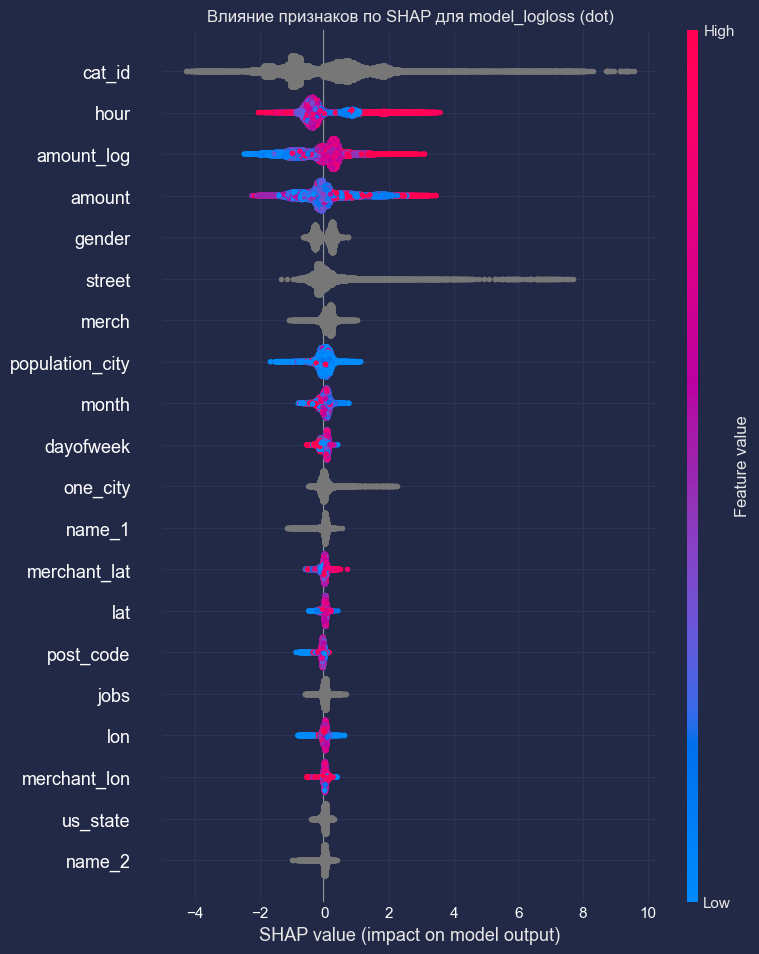

In [33]:
# DOT plot
shap.summary_plot(shap_values, X_valid, feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Влияние признаков по SHAP для model_logloss (dot)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.show()

### Вторая лучшая модель по скору

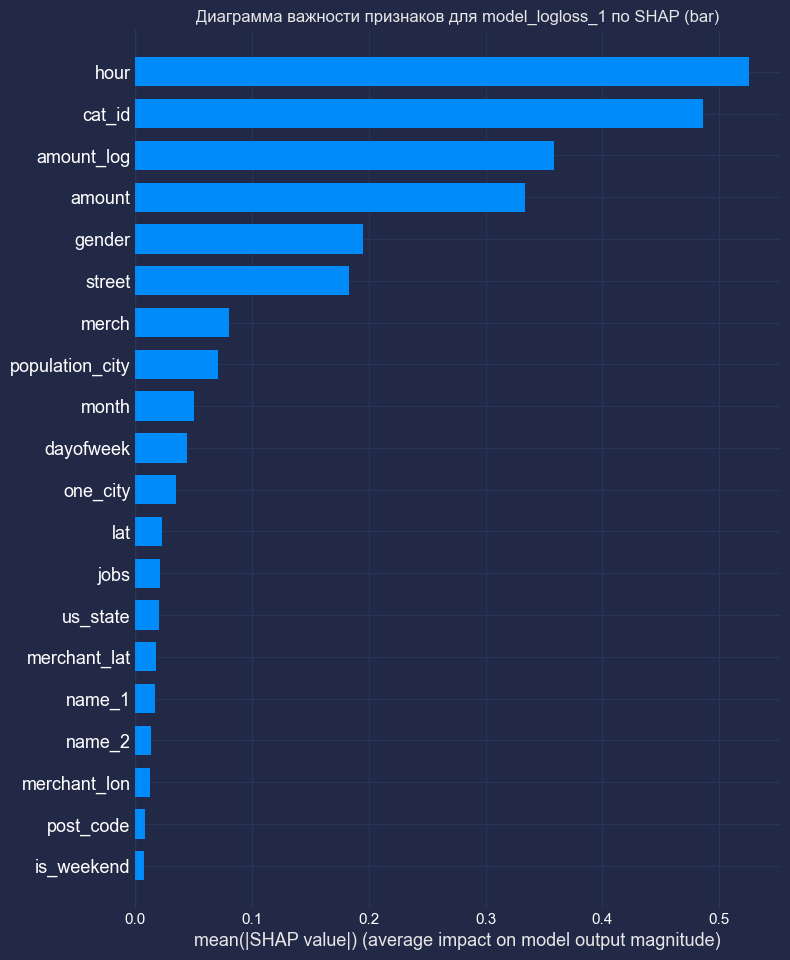

In [34]:
# Получаем SHAP-значения. Для бинарной классификации CatBoost возвращает массив (n_samples, n_features + 1)
shap_values_1 = model_logloss_1.get_feature_importance(data=valid_pool, type='ShapValues')
# Удаляем последний столбец (base value)
shap_values_1 = shap_values_1[:, :-1]

# BAR plot
shap.summary_plot(shap_values_1, X_valid, plot_type="bar", feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Диаграмма важности признаков для model_logloss_1 по SHAP (bar)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.show()

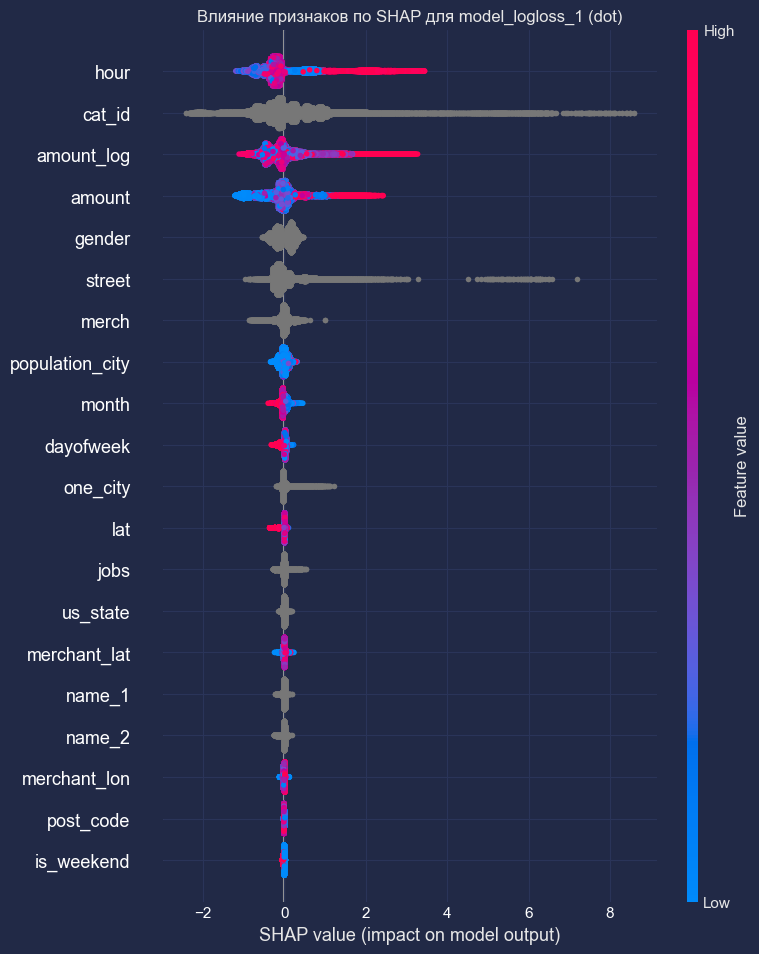

In [35]:
# DOT plot
shap.summary_plot(shap_values_1, X_valid, feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Влияние признаков по SHAP для model_logloss_1 (dot)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.show()

## Применимость решения в бизнесе

- Модель может быть использована как часть системы антифрода для банков или платёжных платформ;
- Предсказания модели можно использовать для приоритизации ручной проверки транзакций;
- SHAP-интерпретация позволяет объяснить решение модели и встроить её в систему принятия решений с человеческим контролем;
- `CatBoost` позволяет без сложных преобразований внедрять модель в production-среду.

## Outro

### Идея №1: Использование кросс-валидации (`KFold` или `StratifiedKFold`)

- **Что даст** — повысит надёжность оценки модели, снизит риск переобучения на одной валидационной выборке.  
- **Что нужно** — заменить `train_test_split` на `KFold(n_splits=5)` или `StratifiedKFold`, особенно при наличии дисбаланса классов.

### Идея №2: Инженерия новых признаков

- **Что даст** — улучшит способность модели выявлять нетипичное поведение, характерное для мошенников.  
- **Что нужно** — создать агрегаты по `user_id` и `terminal_id`, например:
  - средняя сумма транзакций;
  - частота операций по дням недели;
  - стандартное отклонение по суммам;
  - флаги редких/необычных времён и терминалов.

### Идея №3: Ансамблирование моделей

- **Что даст** — повысит точность и устойчивость предсказаний.  
- **Что нужно** — объединить CatBoost с другими моделями (например, `LogisticRegression`, `LightGBM`) через:
  - стекинг (stacking);
  - бутстрап-ансамблирование (bagging);
  - взвешенное усреднение вероятностей.

Так что постараюсь учесть свои ошибки в обоих дз в следующем дз.